# Photon Propagation


In [1]:
from crpropa import *

sim = ModuleList()
sim.add(SimplePropagation())
sim.add(Redshift())
sim.add(EMPairProduction(CMB,True))
sim.add(EMPairProduction(IRB_Gilmore12,True))
sim.add(EMPairProduction(URB_Protheroe96,True))
sim.add(EMDoublePairProduction(CMB,True))
sim.add(EMDoublePairProduction(IRB_Gilmore12,True))
sim.add(EMDoublePairProduction(URB_Protheroe96,True))
sim.add(EMInverseComptonScattering(IRB_Gilmore12,True))
sim.add(EMInverseComptonScattering(CMB,True))
sim.add(EMInverseComptonScattering(URB_Protheroe96,True))
sim.add(EMTripletPairProduction(CMB,True))
sim.add(EMTripletPairProduction(IRB_Gilmore12,True))
sim.add(EMTripletPairProduction(URB_Protheroe96,True))
sim.add(MinimumEnergy(0.01 * EeV))
obs = Observer()
obs.add(ObserverPoint())
obs.add(ObserverInactiveVeto())
t = TextOutput("photon_electron_output.txt",Output.Event1D)
obs.onDetection(t)
source = Source()
source.add(SourcePosition(Vector3d(4,0,0)*Mpc))
source.add(SourceRedshift1D())
source.add(SourceParticleType(22))
source.add(SourceEnergy(1000*EeV))
sim.add(obs)
sim.run(source,10000,True)


### (Optional)  plotting of the results

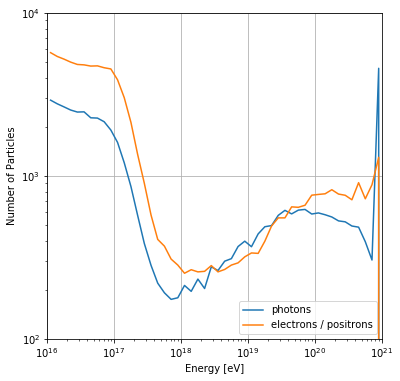

In [2]:
%matplotlib inline
from pylab import *

t.close()
figure(figsize=(6,6))

a = loadtxt("photon_electron_output.txt")
E = logspace(16,23,71)
idx = a[:,1] == 22
photons = a[idx,2] * 1e18
idx = fabs(a[:,1]) == 11
ep = a[idx,2] * 1e18
data,bins = histogram(photons,E)
bincenter = (E[1:] -E[:-1])/2 + E[:-1]
plot(bincenter, data,label="photons")
data,bins = histogram(ep,E)
plot(bincenter, data, label="electrons / positrons")
grid()
loglog()
xlim(1e16, 1e21)
ylim(1e2, 1e4)
legend(loc="lower right")
xlabel("Energy [eV]")
ylabel("Number of Particles")
show()

# Photon Propagation outside of CRPropa with EleCa and DINT

There are two main ways to propagate electromagenetic particle (EM particles: photons, electrons, positrons) in CRPropa.
1) propagation as part of the CRPropa simulation chain
2) propagation outside of the CRPropa simulation chain

The following describes option 2, for which CRPropa provides three functions.
EM particles can either be propagated individually using the external EleCa code (suitable for high energies), or their spectra can be propapagated with the transport code DINT (suitable for low energies).
Alternatively, a combined option is available that processes high energy photons with Eleca and then calculates the resulting spectra with DINT down to low energies.

All three functions take as input a plain-text file with EM particles in the format given in the "Photons from Proton Propagation" example below.
In the following examples the input file "photon_monoenergetic_source.dat" contains 1000 photons with E = 50 EeV from a photon source at 4 Mpc distance.

The last example "Photons from Proton Propagation" shows how to obtain secondary EM particles from a simulation of hadronic cosmic rays.

Note that the differing results in EleCa (and correspondingly the high energy part of the combined option) are due to an incorrect sampling of the background photon energies in EleCa. The EleCa support will be removed in the near future.



### Propagation with EleCa


In [3]:
import crpropa

# Signature: ElecaPropagation(inputfile, outputfile, showProgress=True, lowerEnergyThreshold=5*EeV, magneticFieldStrength=1*nG, background="ALL")
crpropa.ElecaPropagation("photon_monoenergetic_source.dat", "photons_eleca.dat", True, 0.1*crpropa.EeV, 0.1*crpropa.nG)



### Propagation with DINT


In [4]:
import crpropa

# Signature: DintPropagation(inputfile, outputfile, IRFlag=4, RadioFlag=4, magneticFieldStrength=1*nG, aCutcascade_Magfield=0)
crpropa.DintPropagation("photon_monoenergetic_source.dat", "spectrum_dint.dat", 4, 4, 0.1*crpropa.nG)



### Combined Propagation

In [5]:
import crpropa

# Signature: DintElecaPropagation(inputfile, outputfile, showProgress=True, crossOverEnergy=0.5*EeV, magneticFieldStrength=1*nG, aCutcascade_Magfield=0)
crpropa.DintElecaPropagation("photon_monoenergetic_source.dat", "spectrum_dint_eleca.dat", True, 0.5*crpropa.EeV, 0.1*crpropa.nG)


### (Optional) Plotting of Results

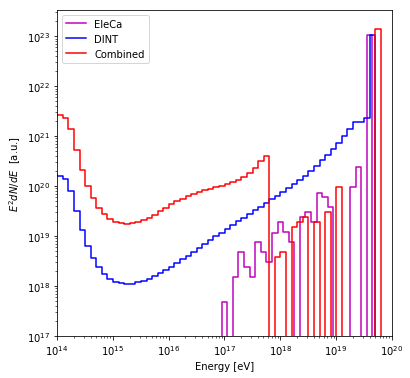

In [6]:
%matplotlib inline
from pylab import *

figure(figsize=(6,6))

loglog(clip_on=False)
yscale("log", nonposy='clip')
xlabel('Energy [eV]')
ylabel ('$E^2 dN/dE$  [a.u.]')

# Plot the EleCa spectrum
elecaPhotons = genfromtxt("photons_eleca.dat")
binEdges = 10**arange(12, 24, .1)
logBinCenters = log10(binEdges[:-1]) + 0.5 * (log10(binEdges[1:]) - log10(binEdges[:-1]))
binWidths = (binEdges[1:] - binEdges[:-1])
data = histogram(elecaPhotons[:,1] * 1E18, bins=binEdges)
J = data[0] / binWidths
E = 10**logBinCenters
step(E, J * E**2,  c='m', label='EleCa')

#Plot the DINT spectrum
data = genfromtxt("spectrum_dint.dat", names=True)
lE = data['logE']
E  = 10**lE
dE = 10**(lE + 0.05) - 10**(lE - 0.05)
J  = data['photons'] / dE
step(E, J * E**2 , c='b', where='mid', label='DINT')

#Plot the combined DINT+EleCa spectrum
data = genfromtxt("spectrum_dint_eleca.dat", names=True)
lE = data['logE']
E  = 10**lE
dE = 10**(lE + 0.05) - 10**(lE - 0.05)
J  = data['photons'] / dE
step(E, J * E**2 , c='r', where='mid', label='Combined')

# Nice limits
xlim(1e14, 1e20)
ylim(bottom=1e17)
legend(loc='upper left')
show()

## Photons from Proton Propagation

The generaton of photons has to be enabled for the individual energy-loss processes in the module chain. Also, separate photon output can be added:

In [7]:
from crpropa import *

# source setup
source = Source()
source.add(SourceParticleType(nucleusId(1, 1)))
source.add(SourcePowerLawSpectrum(10 * EeV, 100 * EeV, -2))
source.add(SourceUniform1D(3 * Mpc, 100.00001 * Mpc))

# setup module list for proton propagation
m = ModuleList()
m.add(SimplePropagation(0, 10 * Mpc))
m.add(MinimumEnergy(1 * EeV))

# observer
obs1 = Observer() # proton output
obs1.add( ObserverPoint() )
obs1.add( ObserverPhotonVeto() ) # we don't want photons here
obs1.onDetection( TextOutput('proton_output.txt', Output.Event1D) )
m.add(obs1)
obs2 = Observer() # photon output
obs2.add( ObserverDetectAll() ) # stores the photons at creation without propagating them
obs2.add( ObserverNucleusVeto() ) # we don't want hadrons here
out2 = TextOutput('photon_output.txt', Output.Event1D)
out2.enable(Output.CreatedIdColumn) # enables the necessary columns to be compatible with the DINT and EleCa propagation
out2.enable(Output.CreatedEnergyColumn)
out2.enable(Output.CreatedPositionColumn)
obs2.onDetection( out2 )
m.add(obs2)

# secondary electrons are disabled here
m.add(ElectronPairProduction(CMB, False))
# enable secondary photons
m.add(PhotoPionProduction(CMB, True))

# run simulation
m.run(source, 10000, True)

The file 'photon_output.txt' will contain approximately 300 photons and can be processed as the photon example above.